# DenseNet - Keras

In this notebook, we will be looking at the DenseNet implementation in Keras. DenseNet is an architecture which build upon the ResNet architecture. In ResNet blocks, the input was **added** to the output of the convolutions. In DenseNet blocks, the input is **concatenated** to the output of convolutions.

The paper is a very easy read and gives the intuition behind the architectural change.

Reference : https://arxiv.org/pdf/1608.06993.pdf

## Imports

In [1]:
from __future__ import division,print_function
from PIL import Image
import gc,re

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Dropout, Convolution2D, \
                        AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K
from keras.datasets import imdb

np.random.seed(7)

from keras.preprocessing.image import load_img, img_to_array

import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from keras import metrics
from scipy.misc import imsave
import imageio

%matplotlib inline

Using TensorFlow backend.


 ## Loading Data
 
Keras has inbuilt CIFAR-10 dataset. We can directly load that. 
It consists of 10 classes of images. Each image is of size 32x32. 
 

In [3]:
from keras.datasets import cifar10

In [4]:
(X_train, y_train), (X_test,y_test) = cifar10.load_data()

X_train.shape , y_train.shape, X_test.shape,y_test.shape, X_train[0].shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1), (32, 32, 3))

Normalize the data ...

In [5]:
X_train = X_train/255.
X_test = X_test/255.

In [6]:
def plot(im,sz):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(im):
        a = fig.add_subplot(sz,sz,i+1)
        plt.imshow(img, cmap='gray')

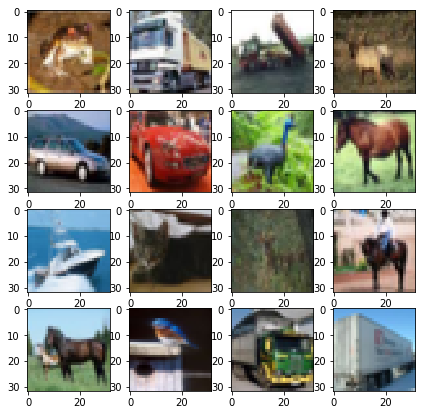

In [7]:
plot(X_train[:16],4)

## Create Model

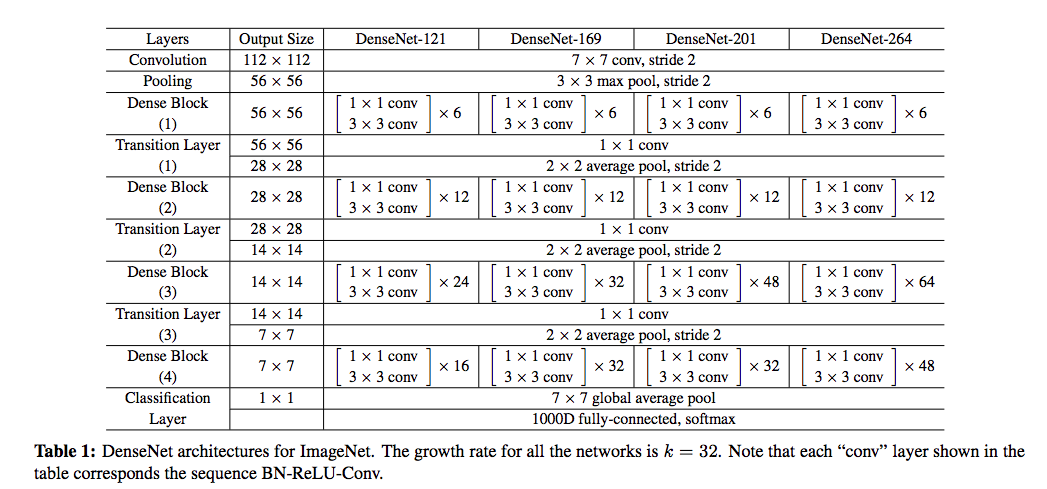

In [8]:
Image.open('/home/kshitijg1992/densenet.png')

This is the architecture of densenet as given in the paper. Here we will be building **DenseNet-169** which **includes bottleneck blocks and compression.**

**Note** 

We will be building a slightly toned down version (i.e. reduce growth rate, and blocks) in order to meet the local computational requirement. Purpose of this notebook was just meant to showcase building of the DenseNet architecture.

### Set Up Model Parts

The basic building block of the DenseNet, as the name suggests, is the **Dense Block**. Each Dense Block is nothing build a set of convolution layers and non linearities.

Each Dense Block consists of two sets of convolution layers, one of kernel size 1x1 and other of kernel size 3x3. The 1x1 conv filters are used for bottleneck. Since the number of inputs keep growing due to concatenation, the computation costs also increase. As such, using 1x1 conv layers can help reduce the dimensionality. Refer to the below link which explains the benefits of using 1x1 conv layers.

Reference : http://iamaaditya.github.io/2016/03/one-by-one-convolution/

Each single conv block consists of BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3).

In [9]:
def conv_block(x, n_filters, dropout_rate=0.0):
    
    # Add 1x1 conv layer - Bottleneck Layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(filters=4*n_filters, kernel_size=(1,1), padding='same')(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # Add 3x3 conv layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
        
    return x
        

In [10]:
def dense_block(x, n_filters, n_layers ,dropout_rate=0.0, growth_rate = 32):
    
    for i in range(n_layers):
        conv_out = conv_block(x, n_filters, dropout_rate)
        x = Concatenate()([x,conv_out])  # axis = -1 for tf (default) and 1 for theano
        n_filters += growth_rate
    return x, n_filters
    

From the paper : 

"We refer to layers between blocks as transition layers, which do convolution and pooling. The transition layers used in our experiments consist of a **batch normalization layer and an 1×1 convolutional layer followed by a 2×2 average pooling layer**"

"To further improve model compactness, we can reduce the number of feature-maps at transition layers. If a dense block contains **m** feature-maps, we let the following transition layer generate **[θ\*m]** output featuremaps, where 0 <θ ≤1 is referred to as the compression factor. When θ = 1, the number of feature-maps across transition layers remains unchanged. We refer the DenseNet with θ <1 as DenseNet-C, and we set θ = 0.5 in our experiment"

In [11]:
def transition_block(x, n_filters, compression_ratio = 0.5, dropout_rate = 0.0):
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    x = Convolution2D(filters=int(n_filters*compression_ratio), kernel_size=(1,1), padding='same')(x)
    
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    x = AveragePooling2D((2,2), strides=(2,2))(x)
    
    return x, int(n_filters*compression_ratio)

In [13]:
def create_densenet(inp):
    
    # Define constants
    n_filters = 16 #64
    n_layers = [6,6,6] #[6,12,32,32] # For DenseNet-169 --> denotes number of dense blocks per layers
    n_dense_blocks = 3 #--> Note : we are using only 3 blocks here as opposed to 4 in paper
    growth_rate = 12
    dropout_rate = 0.2
    compression_ratio = 0.5
    n_classes = 10
    
    ## Set Up the Initial Conv layer
    x = Convolution2D(filters=n_filters, kernel_size=(1,1), strides=(2,2), padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    x = MaxPooling2D((3,3), strides=(2,2))(x)
    
    # There are 4 dense blocks and 3 transision blocks. We dont have transition block for the last dense block.
    for block in range(n_dense_blocks-1):
        
        ## Add Dense Block
        x, n_filters = dense_block(x, n_filters, n_layers[block], dropout_rate, growth_rate)
        
        ## Add Transition Block
        x, n_filters = transition_block(x, n_filters, compression_ratio, dropout_rate)
    
    # Now to add the final dense block
    x, n_filters = dense_block(x, n_filters, n_layers[n_dense_blocks-1], dropout_rate, growth_rate)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    
    # Add the GlobalAveragePooling2D layer
    
    x = GlobalAveragePooling2D()(x)
    outp = Dense(n_classes, activation='softmax')(x)
    
    return outp

In [14]:
inp = Input(shape=(32,32,3))
outp = create_densenet(inp)

model = Model(inputs=inp, outputs=outp)

sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   64          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

## Train Model

In [15]:
model.fit(X_train, y_train, batch_size=128, epochs=1, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 65s 2ms/step - loss: 2.0151 - acc: 0.2615 - val_loss: 2.9059 - val_acc: 0.1088


In [16]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 58s 1ms/step - loss: 1.7182 - acc: 0.3683 - val_loss: 1.8224 - val_acc: 0.3341
Epoch 2/10
40000/40000 [==============================] - 54s 1ms/step - loss: 1.6053 - acc: 0.4128 - val_loss: 1.5706 - val_acc: 0.4238
Epoch 3/10
40000/40000 [==============================] - 55s 1ms/step - loss: 1.5178 - acc: 0.4497 - val_loss: 1.8365 - val_acc: 0.3846
Epoch 4/10
40000/40000 [==============================] - 55s 1ms/step - loss: 1.4609 - acc: 0.4708 - val_loss: 1.5679 - val_acc: 0.4477
Epoch 5/10
40000/40000 [==============================] - 55s 1ms/step - loss: 1.4035 - acc: 0.4958 - val_loss: 1.5110 - val_acc: 0.4679
Epoch 6/10
40000/40000 [==============================] - 54s 1ms/step - loss: 1.3602 - acc: 0.5089 - val_loss: 1.4811 - val_acc: 0.4968
Epoch 7/10
40000/40000 [==============================] - 54s 1ms/step - loss: 1.3169 - acc: 0.5276 - val_loss: 1.4370 - val_acc

In [17]:
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 57s 1ms/step - loss: 1.1796 - acc: 0.5800 - val_loss: 1.3854 - val_acc: 0.5341
Epoch 2/20
40000/40000 [==============================] - 54s 1ms/step - loss: 1.1538 - acc: 0.5924 - val_loss: 1.2960 - val_acc: 0.5739
Epoch 3/20
40000/40000 [==============================] - 55s 1ms/step - loss: 1.1263 - acc: 0.5988 - val_loss: 1.3390 - val_acc: 0.5513
Epoch 4/20
40000/40000 [==============================] - 55s 1ms/step - loss: 1.1035 - acc: 0.6112 - val_loss: 1.3614 - val_acc: 0.5482
Epoch 5/20
40000/40000 [==============================] - 55s 1ms/step - loss: 1.0835 - acc: 0.6185 - val_loss: 1.2904 - val_acc: 0.5751
Epoch 6/20
40000/40000 [==============================] - 55s 1ms/step - loss: 1.0603 - acc: 0.6246 - val_loss: 1.2894 - val_acc: 0.5755
Epoch 7/20
40000/40000 [==============================] - 55s 1ms/step - loss: 1.0432 - acc: 0.6341 - val_loss: 1.3470 - val_acc

In [18]:
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2)
model.save_weights('densenets.h5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 55s 1ms/step - loss: 0.8375 - acc: 0.7057 - val_loss: 1.1594 - val_acc: 0.6334
Epoch 2/20
40000/40000 [==============================] - 55s 1ms/step - loss: 0.8233 - acc: 0.7099 - val_loss: 1.1605 - val_acc: 0.6398
Epoch 3/20
40000/40000 [==============================] - 55s 1ms/step - loss: 0.8129 - acc: 0.7137 - val_loss: 1.1511 - val_acc: 0.6369
Epoch 4/20
40000/40000 [==============================] - 55s 1ms/step - loss: 0.8080 - acc: 0.7127 - val_loss: 1.2241 - val_acc: 0.6258
Epoch 5/20
40000/40000 [==============================] - 55s 1ms/step - loss: 0.7867 - acc: 0.7231 - val_loss: 1.1765 - val_acc: 0.6481
Epoch 6/20
40000/40000 [==============================] - 54s 1ms/step - loss: 0.7758 - acc: 0.7264 - val_loss: 1.3517 - val_acc: 0.6222
Epoch 7/20
40000/40000 [==============================] - 55s 1ms/step - loss: 0.7351 - acc: 0.7399 - val_loss: 1.2245 - val_acc